# Replication of Kozlowski *et al.* "The Geometry of Culture: Analyzing the Meanings of Class through Word Embeddings"

| Author | Last update |
|:------ |:----------- |
| Hauke Licht (https://github.com/haukelicht) | 2023-09-26 |

In their often-cited [publication](https://journals.sagepub.com/doi/full/10.1177/0003122419877135) "The Geometry of Culture: Analyzing the Meanings of Class through Word Embeddings," Kozlowski, Taddy, and Evans show thar conceptual dimensions in the embedding spaces correspond to dimensions of cultural meaning, and words' relation with these dimensions reflects widely shared cultural associations.

## Replication: goals and approach

In this notebook, we replicate parts of their analyses.
Our goal is to see if we find the same patterns they describe in their publication.
We do this using their original word lists but a different word embedding model (I believe).

## Setup

In [1]:
import os

import numpy as np
import pandas as pd

import gensim
import gensim.downloader as api

from scipy.spatial.distance import cosine
cosine_similarity = lambda x, y: 1 - cosine(x, y)

import matplotlib.pyplot as plt

data_path = os.path.join('..', 'data', 'replications', 'kozlowski_geometry_2019')

In [2]:
# load a pre-trained word2vec model (shipped with gensim)
word2vec = api.load('word2vec-google-news-300')

## Kozlowski *et al.* measurment strategy


#### *1. Inducing dimensions*

Kozlowski et al. explain that their technique for inducing cultural dimensions in the word embedding vector space builds on logic of **solving analgoy tasks**:

- Adding the vector $(v_{\text{affluence}}−v_{\text{poverty}})$ to a word's embedding is equivalent to taking one "step" in the direction of affluence.
- To tap more broadyl into this latent "affluence" dimension, you can do the same computation for more polar word pairs than just ('affluence', 'poverty'), such as 
such as ('rich', 'poor'), ('priceless', 'worthless'), or ('prosperous', 'bankrupt').
- Averaging the differences of several related antonym pairs then yields "a single, robust affluence dimension".

#### *2. Computing words' associations*

To identify the cultural associations/valence of a word, they compute the cosine similarity of its normalized vector with a given cultural dimension.

*Note:* They note that this is similar to "calculate the orthogonal projection of the word vector onto the cultural dimension of interest."

**_Interpretation_**

Say the class dimensions is constructed from the polar word pairs  ('affluence', 'poverty') , ('rich', 'poor'), ('priceless', 'worthless'), etc.
Then a more positive cosien value  would indicate association with affluence, and more negative values an association with poverty.

#### Summary of ingredients

1. a pre-trained word embedding
1. a set of polar word (i.e., antonym) pairs for each cultural dimension
2. a bunch of words that should be related to ("projected onto") these dimensions

## Implementing their analyses with `gensim`

### 1. Load the antonym words pairs

I have prepared the data in their category-specific antony word pairs lists into a long tab-separated file:

In [3]:
fp = os.path.join(data_path, 'antonyms.tsv')
with open(fp, 'r') as file:
    antonyms = [line.strip().split('\t') for line in file.readlines()]

In [4]:
# old: df = pd.DataFrame(antonyms, columns=['dimension', 'pair'])

# convert antonyms into a data frame with column names 'dimension' and 'pair'
df = pd.read_csv(fp, sep='\t', header=None, names=['dimension', 'pair'])
# split column pair into separate columns
df = df.join(df['pair'].str.split('-', expand=True).rename(columns={0:'word1', 1:'word2'}))
df

,dimension,pair,word1,word2
0,Affluence,rich-poor,rich,poor
1,Affluence,richer-poorer,richer,poorer
2,Affluence,richest-poorest,richest,poorest
3,Affluence,affluence-poverty,affluence,poverty
4,Affluence,affluent-destitute,affluent,destitute
...,...,...,...,...
152,Morality,guiltless-guilty,guiltless,guilty
153,Morality,decent-indecent,decent,indecent
154,Morality,chaste-unsavory,chaste,unsavory
155,Morality,righteous-odious,righteous,odious


### 2. Inducing a dimensions using antonym pairs 

Kozlowski's approach is to 

1. span vectors between the polar terms in each word pair (by subtracting the second term's embedding from the first one's) , and
2. then average these 'direction' vectors into one vector

They do this for *each* dimension separately!

In [60]:
# TODO: compute the average direction vector for each dimension
#    1. for each dimension
#        1. compute the difference vector between each antonym pair
#        2. average the difference vectors into one vector
#        3. store the average vector in the dictionary `dims`, using dimensions names as keys

dims = {}

# group df by 'dimension' and iterate over groups
for dim, group in df.groupby('dimension'):
    # use a list to stor the difference vectors
    diffs = []
    # iterate over antonym pairs
    for i, r in df[df.dimension == dim].iterrows():
        # TODO: compute the difference vector between the two words
    # TODO: average antonym pairs' difference vectors (acros 'rows')

Now we have one vector per cultural dimension that points from one set of polar terms to the opposite of polar terms for each dimension.

In [61]:
dims.keys()

dict_keys(['Affluence', 'Cultivation', 'Education', 'Employment', 'Gender', 'Morality', 'Race', 'Status'])

In [62]:
dims['Affluence'].shape

(300,)

### 3. Computing associations of words with cultural dimensions 

**_Note_** to perform the following computations, we need to normalize vectors. 
Here is a helper function to do this:

In [4]:
# normalizing the vectors
normalize_vector = lambda x: x / np.linalg.norm(x)

#### Example with the "gender" dimension

Let's check whether the occupation names 'manager' and 'secretary' are associated differently with our gender dimension:

In [5]:
df[df.dimension=='Gender']

NameError: name 'df' is not defined

In [3]:
manager = normalize_vector(word2vec['manager'])
secretary = normalize_vector(word2vec['secretary'])

# TODO: ensure that this code runs (your entry in `dims['Gender']` needs to be a (300,)-shaped numpy array)
print('manager:', cosine_similarity(manager, normalize_vector(dims['Gender'])))
print('secretary:', cosine_similarity(secretary, normalize_vector(dims['Gender'])))

print('\nfor comparison:')
print('man:', cosine_similarity(normalize_vector(word2vec['man']), normalize_vector(dims['Gender'])))
print('woman:', cosine_similarity(normalize_vector(word2vec['woman']), normalize_vector(dims['Gender'])))

NameError: name 'normalize_vector' is not defined

**Interpretation:** 
'Manager' is more associated with the "male" pole of the gender dimension.
'Secretary' is more associated with the "female" pole of the gender dimension.

#### Implementation with all terms and the "affluence" dimensions

Let's load the terms

In [77]:
fp = os.path.join(data_path, 'cultural_association_words.tsv')
df = pd.read_csv(fp, sep='\t')
df.category.value_counts()

category
Occupations    11
Clothing       10
Sports          9
Name            8
Music           7
Vehicles        7
Food            7
Name: count, dtype: int64

Because these terms are likely to have been used more in their lowercase versions, we'll lowercase them:

In [78]:
df['word'] = df['word'].str.lower()

Now, let's get the list of categories in `df` and compute scores for the "Affluence" dimension of culture:

In [81]:
# example with the "affluence" dimension
dim = 'Affluence'
scores = []

for i, r in df.iterrows():
    # note: we include only words that are in our models' vocabulary
    if r.word not in word2vec.key_to_index:
        continue
    else:
        v = normalize_vector(word2vec[r.word])
    scores += [(r.category, r.word, cosine_similarity(v, dims[dim]))]

scores_df = pd.DataFrame(scores, columns=['category', 'word', 'association'])
scores_df[scores_df.category=='Clothing']

,category,word,association
11,Clothing,blouse,0.048764
12,Clothing,briefcase,0.044432
13,Clothing,dress,0.069688
14,Clothing,necklace,0.093651
15,Clothing,pants,-0.044441
16,Clothing,shirt,-0.000721
17,Clothing,shorts,-0.047432
18,Clothing,socks,-0.099759
19,Clothing,suit,0.049307
20,Clothing,tuxedo,0.139914


Let's visualize terms associations with the Affluence dimension (by category):

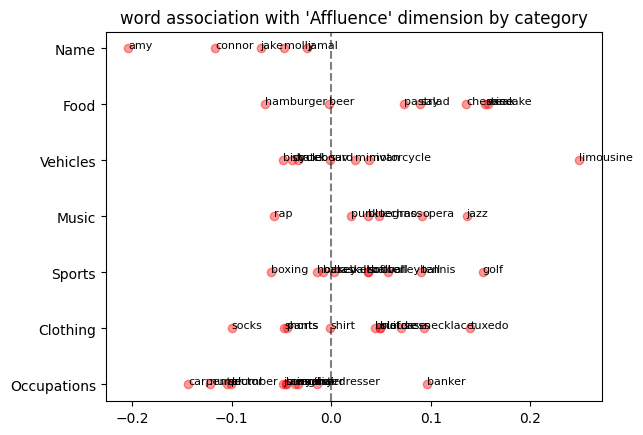

In [82]:
# import matplotlib
import matplotlib.pyplot as plt 

plt.scatter(scores_df.association, scores_df.category, c='r', alpha=0.4)
plt.title("word association with 'Affluence' dimension by category")
# draw a vertocal line at 0
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
# plot the labels of the words on top of the points
for i, r in scores_df.iterrows():
    plt.text(r.association, r.category, r.word, fontsize=8)

**_Note:_** Please let me know if you find a better way to visualize the data!

Because the plot above overplots a lot, let's have a look at only terms in the occupation category:

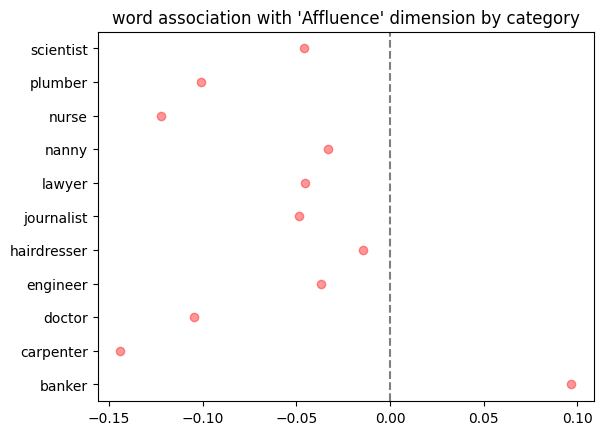

In [83]:
tmp = scores_df[scores_df.category=='Occupations']
plt.scatter(tmp.association, tmp.word, c='r', alpha=0.4)
plt.title("word association with 'Affluence' dimension by category")
# draw a vertocal line at 0
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)

### Replicate their Figure 3

In [84]:
# TODO: compute the associations of the following words with the 'Affluence' and 'Race' dimensions

words = "jazz rap opera punk techno hip_hop bluegrass".split(' ')

# use this dictionary to gather results
associations = {}
for dim in ['Affluence', 'Race']:
    print(dim)
    associations[dim] = {}
    for w in words:
        # TODO: compute the cosine similarity between the word vector and the dimension vector
        associations[dim][w] = cs
        print(w, cs)
    print()

Affluence
jazz 0.13604150712490082
rap -0.057141538709402084
opera 0.09137751907110214
punk 0.020281970500946045
techno 0.04845239967107773
hip_hop 0.041844647377729416
bluegrass 0.037409041076898575

Race
jazz 0.1767650544643402
rap 0.27025365829467773
opera -0.029356295242905617
punk 0.0314621739089489
techno 0.07046493142843246
hip_hop 0.3324428200721741
bluegrass 0.07064911723136902



In [5]:
tmp = pd.DataFrame(associations).reset_index(names=['word'])

# TODO: create a scatter plot of the associations of the words, showing the 'Race' dimension on the x-axis and the 'Affluence' dimension on the y-axis  

NameError: name 'associations' is not defined

### Replicate their Figure 5

In [23]:
# TODO: compute all dimensions similarities with one another

# create all combinations of list ['a', 'b', 'c'] with length 2
import itertools

dim_sims = {d: {} for d in dims}
nms = list(dims.keys())
dim_pairs = set(itertools.combinations(nms, 2))

for p in dim_pairs:
        dim_sims[p[0]][p[1]] = # TODO: compute the cosine similarity between the two dimension vectors (stored as first and second element of current value of `p`)

In [24]:
# create a data frame from the dictionary
tmp = pd.DataFrame(dim_sims)
tmp = tmp.loc[reversed(nms[1:]), nms]

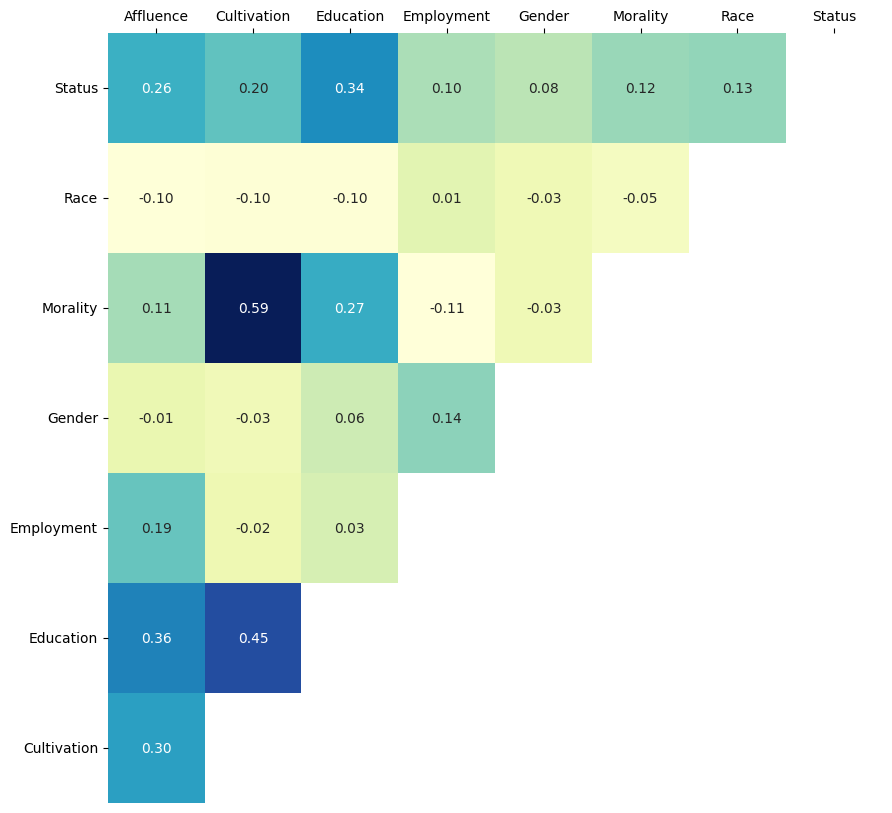

In [25]:
import seaborn as sns

# TODO: create a heatmap of values in tmp with seaborn


**_Note:_** Kotzlowski et al. (2019) report the following similarities of other dimensions with the 'Affluence' (class) dimension in Figure 5 for the period 1990:

- Education: 0.42
- Cultivation: 0.31
- Status: 0.23
- Morality: 0.1
- Employment: 0.08
- Gender: -.05

Our estimates are super similar!
